In [13]:
"""Count: process llama65b data."""

import os
import copy
import itertools
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pprint

def clean_for_claude(result):
    if 'answer is' in result:
            idx = result.find('answer is')+len('answer is')
            key = result[idx:idx+30]
            return key
    if 'in:' in result:
        idx = result.find('in:')+len('in:')
        key = result[idx:idx+30]
        return key
    # result = result.replace('### Assistant:','')
    if any(i in result for i in ['could be anywhere','<none>','t determine', 'N/A', 'is unknown', 'cannot be determined', "enough information",'my final answer would be either']):
        return 'unknown'
    result = result.split('\n\n')
    if any(i in result[-1] for i in ['Hope', 'Does', 'Happy', 'et me know', 'Even though Liam told Noah differently', 'Explanation:']):
        result = result[:-1]
    if 'The key' in result[-1]:
        result = result[:-1]
    key = result[-1]
    key = key.split('\n')[-1]
    if all([i not in key[-30:] for i in ['red_', 'blue_', 'green_']]):
        if 'Which is what' in key or 'This is because' in key:
            return result[-2]
        return key
    return key[-30:]

def clean_for_gpt(result):
    if len(result)<30:
        return result
    if 'answer is' in result:
        idx = result.find('answer is')+len('answer is')
        key = result[idx:idx+30]
        return key
    if any(i in result for i in ['Insufficient information','None of the options','cannot answer','cannot provide any information','cannot know','could be anywhere','<none>','t determine', 'N/A', 'is unknown', 'cannot be determined', "enough information",'my final answer would be either']):
        return 'unknown'
    key = result.split('\n')[-2:]
    return key[-1]

def clean_for_guanaco(result):
    return result[-150:]

def clean(result, result_folder):
        if 'Claude' in result_folder:
            return clean_for_claude(result)
        if 'gpt' in result_folder:
            return clean_for_gpt(result)
        return clean_for_guanaco(result)
    
def correct(result, choice, ans):
    if any([i in result for i in ['red', 'blue', 'green']]):
        if ans in result.lower():
            return 1
        else:
            return 0
    if choice in result:
        return 1
    return 0

    
    

1184


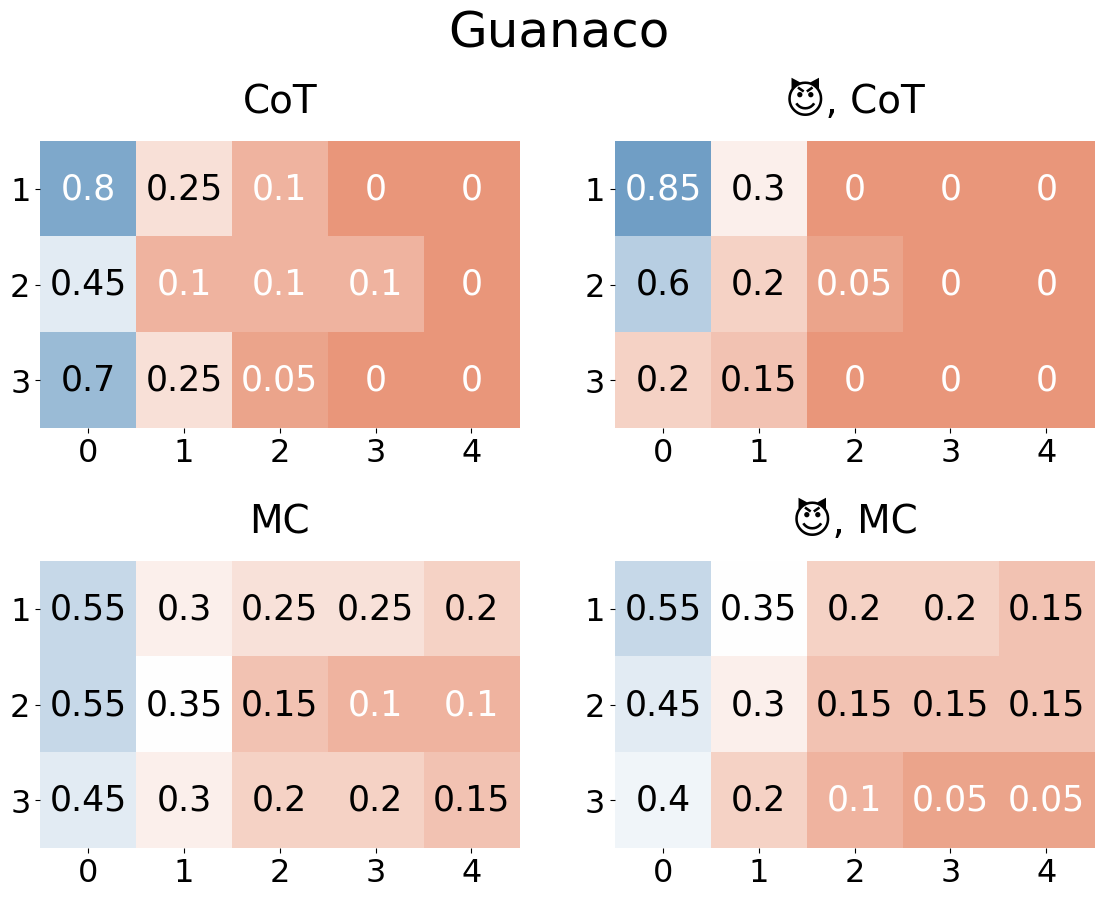

In [77]:
"""Draw the plot"""
model = 'Guanaco'

match model:
    case 'Guanaco':
        result_folder = 'result_llama65b-v1'
    case 'Claude':
        result_folder = 'result_Claude-instant'
    case 'GPT_3.5':
        result_folder = 'result_gpt-3.5-turbo-v0'

# result_folder = 'result_llama65b-v1'
# result_folder = 'result_gpt-3.5-turbo-v0'
# result_folder = 'result_Claude-instant'
acc = {}
ans_folder = "data_ToMh_old"


have = 0
# Iterate over all files and subdirectories within the root folder
for folder_name, subfolders, filenames in os.walk(result_folder):
    for filename in filenames:
        if filename.endswith(".txt"):
                ans_folder_name = folder_name.replace(result_folder, ans_folder)
                have += 1
                with open(os.path.join(ans_folder_name, filename), "r") as f:
                    output = f.read()
                    ans = output[output.find('Answer: '):]
                    ans = ans[:ans.find('\n')]
                    ans = ans.split()[-1]
                    choice = output[output.find('Choices:'):]
                    choice = choice[choice.find(ans)-3]
                    ans = ans.replace('_',' ')

                with open(os.path.join(folder_name, filename), "r") as f:
                    result = f.read()
                    result = clean(result, result_folder)
                    result = result.replace('_',' ')
                    # print(result)
                    acc_path  = os.path.join(folder_name, filename).replace(result_folder,'')       
                acc[acc_path] = correct(result, choice, ans)
print(have)

# joint acc
joint_acc = copy.deepcopy(acc)
for key, value in acc.items():
    if value == 0:
        index = 2+key.find('r_')
        o = int(key[index]) + 1
        for i in range(o, 5):
            # print('r_'+key[index])
            new_k = key.replace('r_'+key[index], 'r_'+str(i))
            # print(key, new_k)
            joint_acc[new_k] = 0
# print(acc)

tells = ['No_Tell', 'Tell']
prompts = ['CoT', 'MC']
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]

accuracy_data_3 = {'Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))},
                'No_Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))}}
joint_accuracy_data_3 = {'Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))},
                'No_Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))}}

for tell, prompt, length, order in itertools.product(tells, prompts, lengths, orders):
    acc_value = 0
    joint_acc_value = 0
    for sample_num in range(1, 21):
        acc_path = f'/{tell}/{prompt}/length_{length}/sample_{sample_num}/order_{order}.txt'
        path = result_folder + acc_path
        if os.path.exists(path):
            acc_value += acc[acc_path]
            joint_acc_value += joint_acc[acc_path]

    accuracy_data_3[tell][prompt][length-1][order] = acc_value / 20
    joint_accuracy_data_3[tell][prompt][length-1][order] = joint_acc_value / 20

"""Draw the plot"""

FONT_SIZE = 25
TICK_SIZE = 23
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 28
SUPTITLE_FONT_SIZE = 36

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
colors = [(0, 'darksalmon'), (0.35, 'white'), (1, 'steelblue')]

blueredcmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

"""Plot 2 combined heatmaps"""
# Show all ticks and label them with the respective list entries
cmap = blueredcmap
fig, axs = plt.subplots(2, 2, figsize=(17,10))
titles = np.array([['CoT', '😈, CoT'], ['MC', '😈, MC']])

im1 = axs[0][0].imshow(joint_accuracy_data_3['No_Tell']['CoT'], cmap=cmap, vmin=0, vmax=1)
im2 = axs[0][1].imshow(joint_accuracy_data_3['Tell']['CoT'], cmap=cmap, vmin=0, vmax=1)
im3 = axs[1][0].imshow(joint_accuracy_data_3['No_Tell']['MC'], cmap=cmap, vmin=0, vmax=1)
im4 = axs[1][1].imshow(joint_accuracy_data_3['Tell']['MC'], cmap=cmap, vmin=0, vmax=1)
for i, j in itertools.product(range(2), range(2)):
    axs[i][j].set_xticks(np.arange(5), rotation=45)
    axs[i][j].set_yticks(np.arange(3), labels=[1, 2, 3])
    communication = 'llama65b, w/ deception, ' if j == 1 else 'llama65b, w/o deception, '
    axs[i][j].set_title(titles[i][j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i][j].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
for t, tell in enumerate(tells):
    for p, prompt in enumerate(prompts):
        rounded = np.round(joint_accuracy_data_3[tell][prompt], 2)
        for i in range(3):
            for j in range(5):
                fontcolor = 'black' if joint_accuracy_data_3[tell][prompt][i][j] < 0.75 and joint_accuracy_data_3[tell][prompt][i][j] > 0.1 else 'white'
                value = rounded[i][j] if rounded[i][j] != 0 else 0
                text = axs[p][t].text(j, i, value,
                            ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, aspect=30)
cbar.ax.set_ylabel('Joint accuracy', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('none')
cbar.remove()
fig.suptitle(model, y=0.98, x=0.43, fontsize=SUPTITLE_FONT_SIZE)

plt.savefig(f'data_figs/CoT_heatmaps_{model}.pdf')

In [56]:
"""Analyze correct answers"""
import os
import sys
import copy
import itertools
import numpy as np
import pprint

input_folder = 'extracted_response'
answer_folder = 'data_ToMh_old'
response_folder = 'API_responses'
output_folder = 'check_GPT-4'
summary_file = 'GPT-4_data.txt'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']

# Count answer occurrence
container_nums = 0
story_cnt = 0
max_container = 0
correct_ans_occur = np.zeros(4)
cnt_correct = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
cnt_correct_same = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
cnt_incorrect = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
cnt_incorrect_same = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}

joint_count_correct = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
joint_count_correct_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_correct = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_correct_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_incorrect = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}
count_incorrect_first = {'No_Tell': np.zeros(5), 'Tell': np.zeros(5)}

first_count = np.zeros(5)
first_correct_count = np.zeros(5)
first_correct_count_claude = np.zeros(5)
notfirst_count = np.zeros(5)
notfirst_correct_count = np.zeros(5)
notfirst_correct_count_claude = np.zeros(5)
containers = ['green_box.', 'blue_box.', 'red_box.', 'green_pantry.', 'blue_pantry.', 'red_pantry.', 'green_bathtub.', 'blue_bathtub.', 'red_bathtub.', 'green_envelope.', 'blue_envelope.', 'red_envelope.', 'green_drawer.', 'blue_drawer.', 'red_drawer.', 'green_bottle.', 'blue_bottle.', 'red_bottle.', 'green_cupboard.', 'blue_cupboard.', 'red_cupboard.', 'green_basket.', 'blue_basket.', 'red_basket.', 'green_crate.', 'blue_crate.', 'red_crate.', 'green_suitcase.', 'blue_suitcase.', 'red_suitcase.', 'green_bucket.', 'blue_bucket.', 'red_bucket.', 'green_container.', 'blue_container.', 'red_container.', 'green_treasure_chest.', 'blue_treasure_chest.', 'red_treasure_chest.']


for tell, prompt, length in itertools.product(tells, prompts, lengths):
    for sample_num in range(1, 21):
        correct_so_far = True
        prev_ans = None
        for order in orders:
            input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            claude_fn = os.path.join('/', tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            response_fn = os.path.join(response_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            answer_fn = os.path.join(answer_folder, tell, 'CoT', f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            with open(answer_fn, 'r') as file:
                lines = file.readlines()
                answer_pool = []
                answer_lines = []
                story_total_line = len(lines) - 5
                splits = np.array_split(list(range(story_total_line)), 4)
                for line_num, line in enumerate(lines):
                    if 'Answer:' in line.split(' '):
                        correct_answer = line.split(' ', 1)[1].split('\n')[0]
                    # check if sentence contains a container
                    elif 'likes' not in line.split(' '):
                        container = [container for container in line.split() if container in containers]
                        answer_pool += container
                # print(answer_pool)
                if order <= 4:
                    for line_num, line in list(enumerate(lines))[::-1]:
                        if correct_answer + '.' in line:
                            for i, split in enumerate(splits):
                                if line_num in split:
                                    correct_ans_occur[i] += 1
                            break
            
            story_cnt += 1
            container_nums += len(answer_pool)
            if len(answer_pool) > max_container:
                max_container = len(answer_pool)
            with open(input_fn, 'r') as file:
                lines = file.readlines()
                if len(lines[0].split(' ')) == 2:
                    answer_line = lines[0].split(' ')[1]
                else:
                    continue

            # Answer occurrence count
            if length in [3]:
                if tell in ['No_Tell', 'Tell']:
                    if correct_answer + '.' in answer_pool[-5]:
                        first_count[order] += 1
                        if claude_fn in acc and acc[claude_fn]:
                            first_correct_count_claude[order] += 1

                    else:
                        notfirst_count[order] += 1
                        if claude_fn in acc and acc[claude_fn]:
                            notfirst_correct_count_claude[order] += 1
                        
print(first_count)
print(notfirst_count)
print('avg:')
# print(np.mean(first_correct_count_claude[3:]) / np.mean(first_count[3:]))
# print(np.mean(notfirst_correct_count_claude[3:]) / np.mean(notfirst_count[3:]))
print(np.mean(first_correct_count_claude) / np.mean(first_count))
print(np.mean(notfirst_correct_count_claude) / np.mean(notfirst_count))


[ 6. 12. 14. 12. 12.]
[69. 67. 65. 67. 67.]
avg:
0.37500000000000006
0.4507462686567164


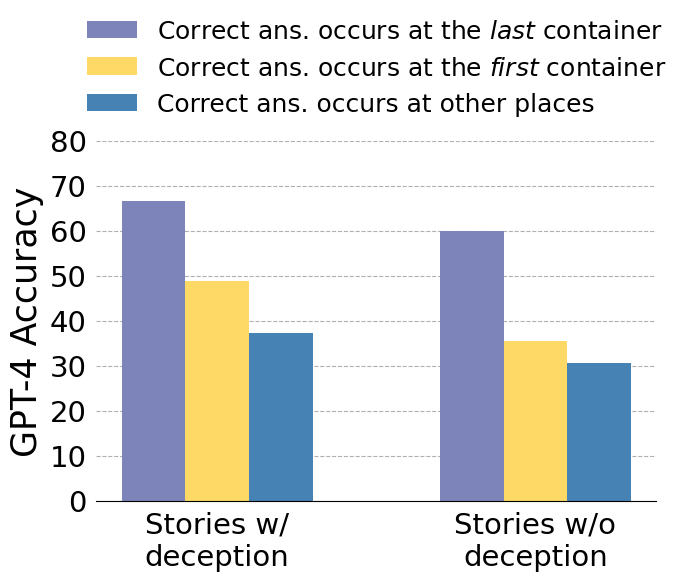

In [126]:
"""Plot: Ratio of correct/incorrect answer in first-container answers"""
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 18

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title

occurrence = ['Last\ncontainer', 'First\ncontainer', 'Other\nplaces']
story_tells = ['Stories w/\ndeception', 'Stories w/o\ndeception']
cols = ['#7C84B9', (1, 0.851, 0.4), 'steelblue']

# Set the positions of the bars
x = np.arange(len(story_tells))
width = 0.2

last_ratio_claude = np.array([0.6666666666666666, 0.6])
first_ratio_claude = np.array([0.4878048780487805, 0.35555555555555557])
other_ratio_claude = np.array([0.37404580152671757, 0.3055555555555556])

# Create the bar chart
# plt.bar(x - width/2, No_Tell_ratio[0], width, label='No deception', zorder=2, color=cols[0])
# plt.bar(x + width/2, Tell_ratio[0], width, label='Exists deception', zorder=2, color=cols[1])
fig = plt.figure(figsize=(7, 6))
plt.bar(x - width, 100 * last_ratio_claude, width, label='Correct ans. occurs at the $\it{last}$ container', zorder=2, color=cols[0])
plt.bar(x, 100 * first_ratio_claude, width, label='Correct ans. occurs at the $\it{first}$ container', zorder=2, color=cols[1])
plt.bar(x + width, 100 * other_ratio_claude, width, label='Correct ans. occurs at other places', zorder=2, color=cols[2])

# Add labels and title
# plt.xlabel('Occurrence of the correct answer')
plt.ylabel('GPT-4 Accuracy')
plt.grid(axis='y', linestyle='dashed', zorder=1)
# plt.title('Bar Chart with Two Columns')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Set the x-axis tick labels
plt.xticks(x, story_tells)
plt.yticks([ 0., 10., 20., 30., 40., 50., 60., 70., 80.])
plt.tick_params(bottom=False, left=False)

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=1, frameon=False)
plt.subplots_adjust(bottom=0.15, top=0.75, left=0.15, right=0.95)

# Display the plot
plt.savefig(f'data_figs/acc_vs_occurrence.pdf')
plt.show()


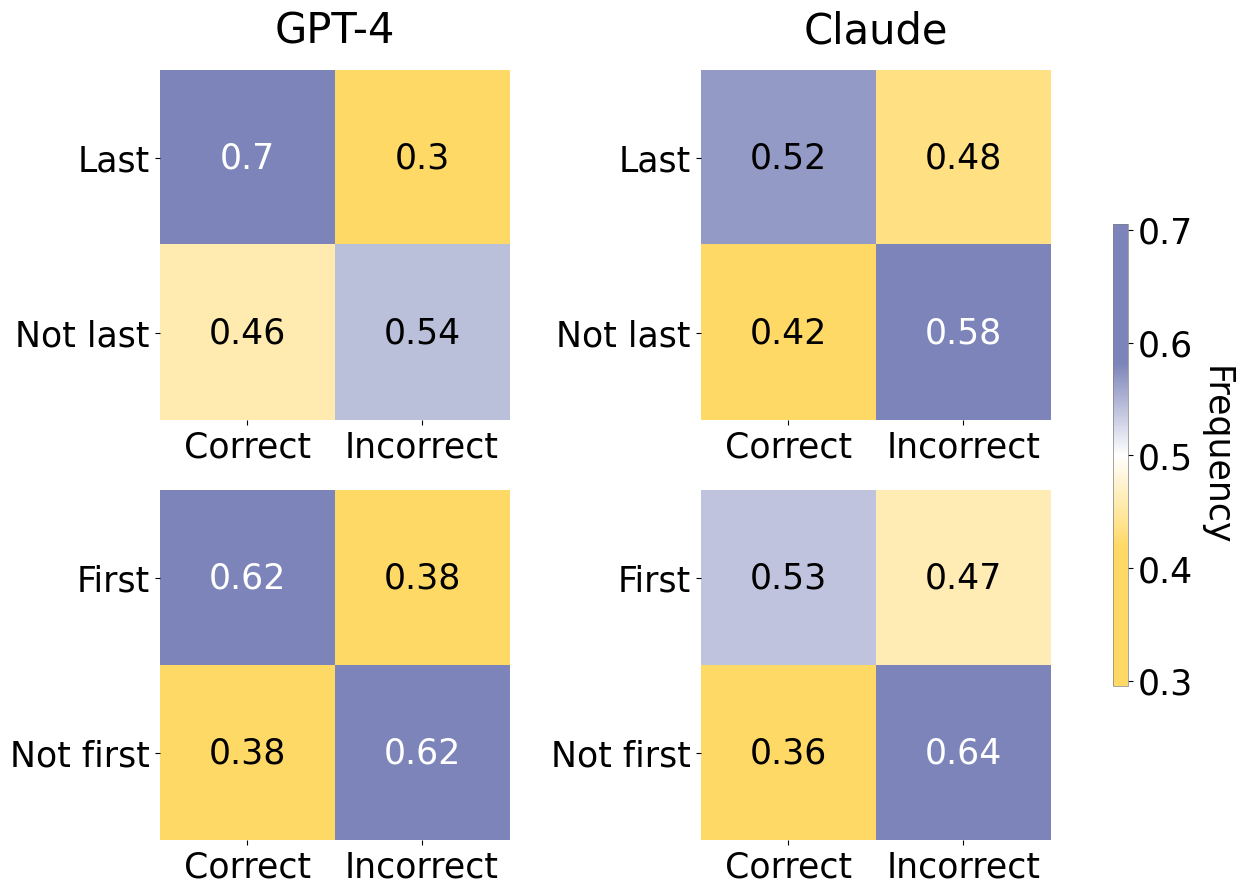

In [25]:
"""confusion matrix"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 25
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

colors = [(0, 'darksalmon'), (0.3, 'darksalmon'), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, '#7C84B9'), (1, '#7C84B9')]
# colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

# data
# GPT-4
last1, last2 = [0.7049180327868853, 0.4575757575757576]
last_confusion_4 = np.array([[last1, 1-last1], [last2, 1-last2]])

# Claude
last1, last2 = [0.5245901639344263, 0.42424242424242425]
last_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

first1, first2 = [0.6170212765957447, 0.3842364532019704]
first_confusion_4 = np.array([[first1, 1-first1], [first2, 1-first2]])

first1, first2 = [0.526595744680851, 0.35960591133004927]
first_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])

# plot
fig, axs = plt.subplots(2, 2, figsize=(16,10))
cmap = cmap
# cmap=mpl.colormaps['Blues']

titles = ['GPT-4', 'Claude']

im1 = axs[0][0].imshow(last_confusion_4, cmap=cmap)
im2 = axs[0][1].imshow(last_confusion_claude, cmap=cmap)
im3 = axs[1][0].imshow(first_confusion_4, cmap=cmap)
im4 = axs[1][1].imshow(first_confusion_claude, cmap=cmap)

for i, j in itertools.product(range(2), range(2)):
    axs[i][j].set_xticks(np.arange(2), rotation=0, labels=['Correct', 'Incorrect'])
    axs[0][j].set_yticks(np.arange(2), labels=['Last', 'Not last'])
    axs[1][j].set_yticks(np.arange(2), labels=['First', 'Not first'])
    # communication = 'w/ deception, ' if j == 1 else 'w/o deception, '
    axs[0][j].set_title(titles[j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i][j].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
matrices = {0: {0: last_confusion_4, 1: last_confusion_claude},
            1: {0: first_confusion_4, 1: first_confusion_claude}}
for x, y, i, j in itertools.product(range(2), range(2), range(2), range(2)):
    data = matrices[x][y]
    rounded = np.round(data, 2)
    fontcolor = 'black' if data[i][j] < 0.55 else 'white'
    text = axs[x][y].text(j, i, rounded[i][j],
                ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, aspect=30)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('grey')
cbar.outline.set_linewidth(0.5)
plt.savefig('data_figs/confusion.pdf')


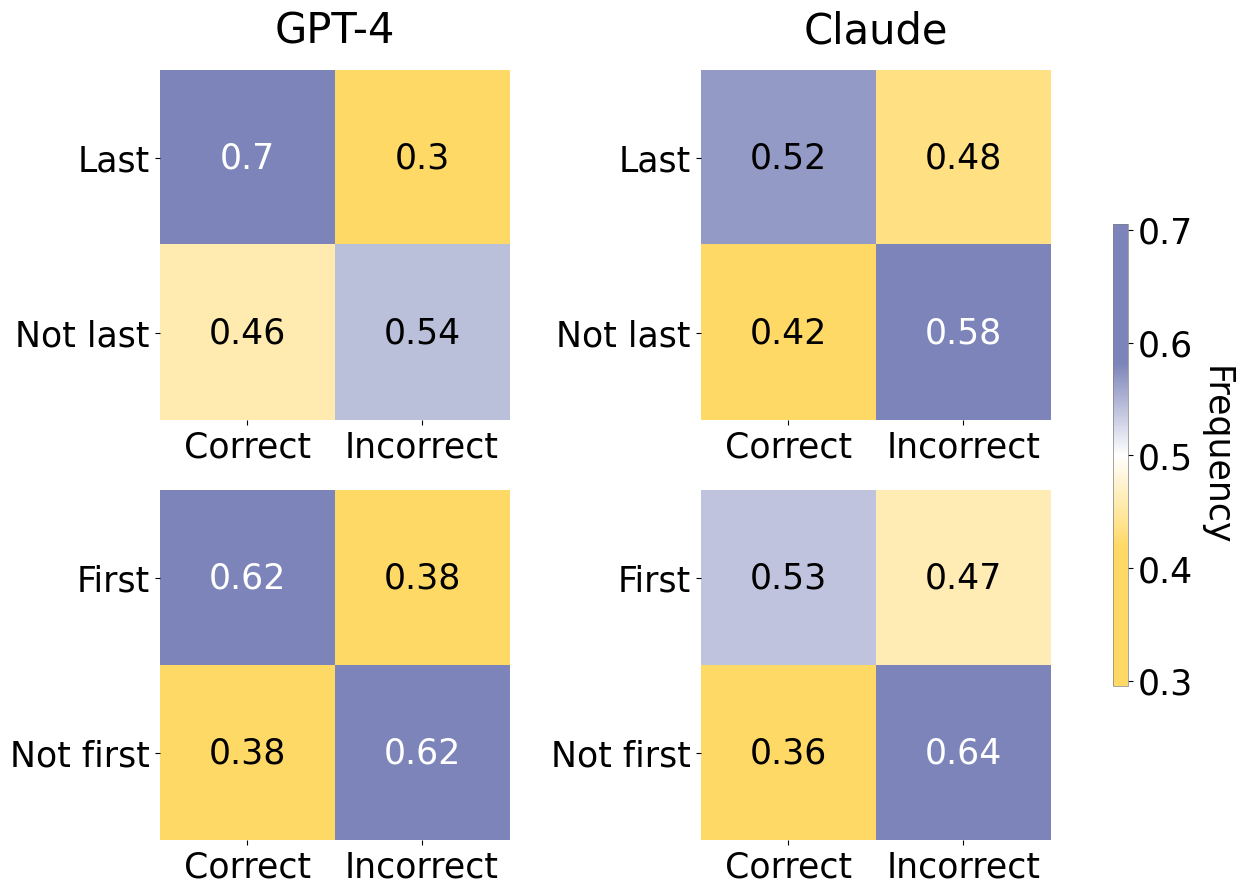

In [127]:
"""Confusion matrix."""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 25
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

colors = [(0, 'darksalmon'), (0.3, 'darksalmon'), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, '#7C84B9'), (1, '#7C84B9')]
# colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

# data
# GPT-4
last1, last2 = [0.7049180327868853, 0.4575757575757576]
last_confusion_4 = np.array([[last1, 1-last1], [last2, 1-last2]])

# Claude
last1, last2 = [0.5245901639344263, 0.42424242424242425]
last_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

first1, first2 = [0.6170212765957447, 0.3842364532019704]
first_confusion_4 = np.array([[first1, 1-first1], [first2, 1-first2]])

first1, first2 = [0.526595744680851, 0.35960591133004927]
first_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])

# plot
fig, axs = plt.subplots(2, 2, figsize=(16,10))
cmap = cmap
# cmap=mpl.colormaps['Blues']

titles = ['GPT-4', 'Claude']

im1 = axs[0][0].imshow(last_confusion_4, cmap=cmap)
im2 = axs[0][1].imshow(last_confusion_claude, cmap=cmap)
im3 = axs[1][0].imshow(first_confusion_4, cmap=cmap)
im4 = axs[1][1].imshow(first_confusion_claude, cmap=cmap)

for i, j in itertools.product(range(2), range(2)):
    axs[i][j].set_xticks(np.arange(2), rotation=0, labels=['Correct', 'Incorrect'])
    axs[0][j].set_yticks(np.arange(2), labels=['Last', 'Not last'])
    axs[1][j].set_yticks(np.arange(2), labels=['First', 'Not first'])
    # communication = 'w/ deception, ' if j == 1 else 'w/o deception, '
    axs[0][j].set_title(titles[j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i][j].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
matrices = {0: {0: last_confusion_4, 1: last_confusion_claude},
            1: {0: first_confusion_4, 1: first_confusion_claude}}
for x, y, i, j in itertools.product(range(2), range(2), range(2), range(2)):
    data = matrices[x][y]
    rounded = np.round(data, 2)
    fontcolor = 'black' if data[i][j] < 0.55 else 'white'
    text = axs[x][y].text(j, i, rounded[i][j],
                ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, aspect=30)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('grey')
cbar.outline.set_linewidth(0.5)
plt.savefig('data_figs/confusion.pdf')


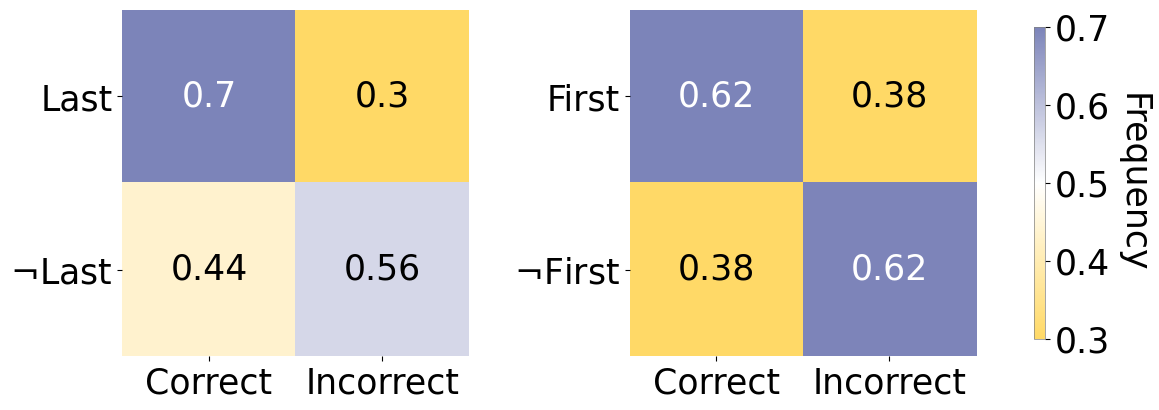

In [25]:
"""GPT-4 confusion matrix."""
import numpy as np
import itertools
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 25
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

# colors = [(0, 'darksalmon'), (0.3, 'darksalmon'), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
colors = [(0, (1, 0.851, 0.4)), (0.5, 'white'), (1, '#7C84B9')]
# colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

# data
last1, last2 = [0.7, 0.43666666666666665]
last_confusion_4 = np.array([[last1, 1-last1], [last2, 1-last2]])

first1, first2 = [0.6170212765957447, 0.3842364532019704]
first_confusion_4 = np.array([[first1, 1-first1], [first2, 1-first2]])


# plot
fig, axs = plt.subplots(1, 2, figsize=(15,4.5))
# cmap=mpl.colormaps['Blues']


im1 = axs[0].imshow(last_confusion_4, cmap=cmap)
im2 = axs[1].imshow(first_confusion_4, cmap=cmap)

for i in range(2):
    axs[i].set_xticks(np.arange(2), rotation=0, labels=['Correct', 'Incorrect'])
    axs[0].set_yticks(np.arange(2), labels=['Last', r'$\neg$Last'])
    axs[1].set_yticks(np.arange(2), labels=['First', r'$\neg$First'])
    # communication = 'w/ deception, ' if j == 1 else 'w/o deception, '
    # axs[0].set_title(titles[j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
matrices = {0: last_confusion_4, 1: first_confusion_4}
for x, i, j in itertools.product( range(2), range(2), range(2)):
    data = matrices[x]
    rounded = np.round(data, 2)
    fontcolor = 'black' if data[i][j] < 0.6 else 'white'
    text = axs[x].text(j, i, rounded[i][j],
                ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.9, aspect=30)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('grey')
cbar.outline.set_linewidth(0.5)
plt.savefig('data_figs/confusion_GPT-4.pdf')


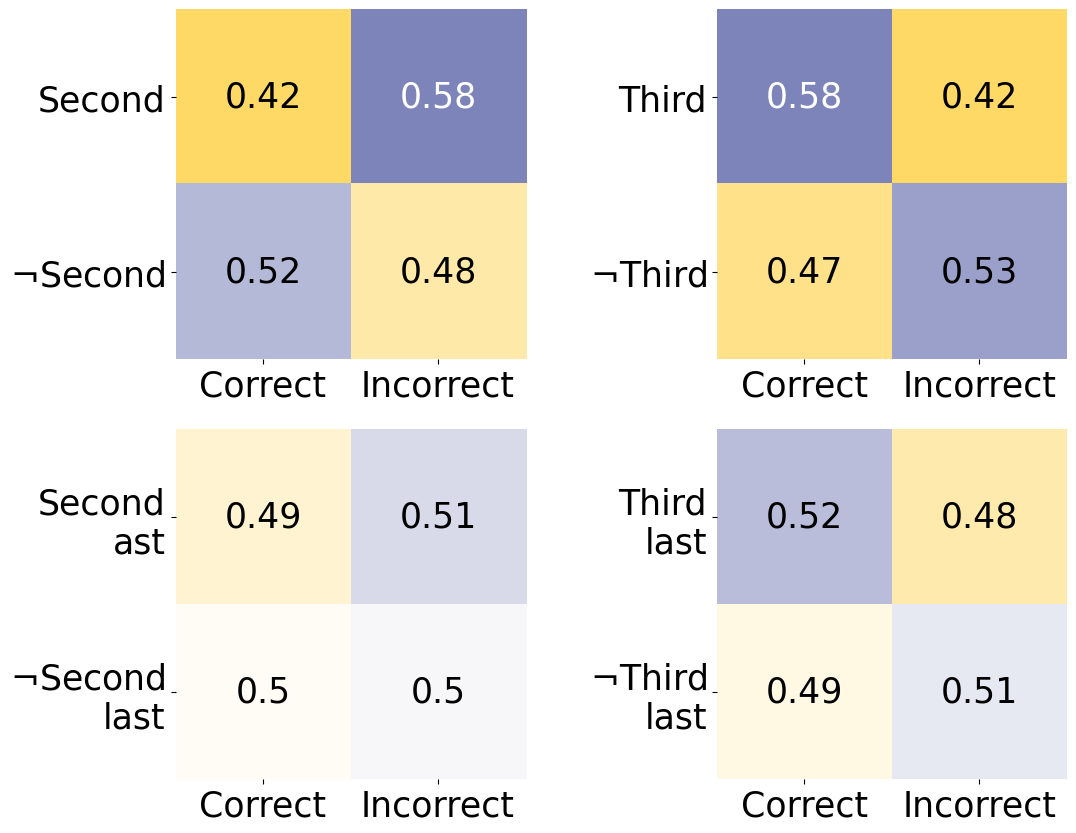

In [63]:
"""GPT-4 other confusion matrix."""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 25
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

colors = [(0, 'darksalmon'), (0.3, 'darksalmon'), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
colors = [(0, (1, 0.851, 0.4)), (0.4, (1, 0.851, 0.4)), (0.5, 'white'), (0.6, '#7C84B9'), (1, '#7C84B9')]
# colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

# data
# second
last1, last2 = [0.42452830188679247, 0.5228070175438596]
last_confusion_4 = np.array([[last1, 1-last1], [last2, 1-last2]])

# third
last1, last2 = [0.5842696629213483, 0.47019867549668876]
last_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

# last second
first1, first2 = [0.48888888888888893, 0.49710982658959535]
first_confusion_4 = np.array([[first1, 1-first1], [first2, 1-first2]])

# last third
first1, first2 = [0.5208333333333334, 0.49271137026239065]
first_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])

# plot
fig, axs = plt.subplots(2, 2, figsize=(16,10))
cmap = cmap
# cmap=mpl.colormaps['Blues']

titles = ['GPT-4', 'Claude']

im1 = axs[0][0].imshow(last_confusion_4, cmap=cmap, vmin=0.3, vmax=0.7)
im2 = axs[0][1].imshow(last_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)
im3 = axs[1][0].imshow(first_confusion_4, cmap=cmap, vmin=0.3, vmax=0.7)
im4 = axs[1][1].imshow(first_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)

for i, j in itertools.product(range(2), range(2)):
    axs[i][j].set_xticks(np.arange(2), rotation=0, labels=['Correct', 'Incorrect'])
    axs[0][0].set_yticks(np.arange(2), labels=['Second', r'$\neg$Second'])
    axs[0][1].set_yticks(np.arange(2), labels=['Third', r'$\neg$Third'])
    axs[1][0].set_yticks(np.arange(2), labels=['Second\nast', r'$\neg$' + 'Second\nlast'])
    axs[1][1].set_yticks(np.arange(2), labels=['Third\nlast', r'$\neg$' + 'Third\nlast'])
    # communication = 'w/ deception, ' if j == 1 else 'w/o deception, '
    # axs[0][j].set_title(titles[j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i][j].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
matrices = {0: {0: last_confusion_4, 1: last_confusion_claude},
            1: {0: first_confusion_4, 1: first_confusion_claude}}
for x, y, i, j in itertools.product(range(2), range(2), range(2), range(2)):
    data = matrices[x][y]
    rounded = np.round(data, 2)
    fontcolor = 'black' if data[i][j] < 0.55 else 'white'
    text = axs[x][y].text(j, i, rounded[i][j],
                ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, aspect=30)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('grey')
cbar.outline.set_linewidth(0.5)
cbar.remove()

plt.savefig('data_figs/confusion_other.pdf')


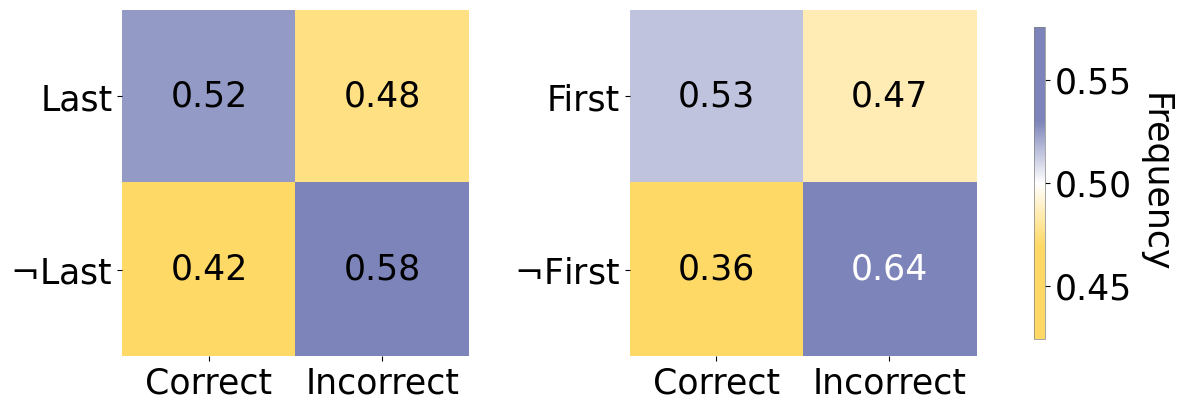

In [30]:
"""Claude confusion matrix."""
import numpy as np
import itertools
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 25
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

# colors = [(0, 'darksalmon'), (0.3, 'darksalmon'), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, '#7C84B9'), (1, '#7C84B9')]
# colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

# Claude
last1, last2 = [0.5245901639344263, 0.42424242424242425]
last_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

first1, first2 = [0.526595744680851, 0.35960591133004927]
first_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])


# plot
fig, axs = plt.subplots(1, 2, figsize=(15,4.5))
# cmap=mpl.colormaps['Blues']


im1 = axs[0].imshow(last_confusion_claude, cmap=cmap)
im2 = axs[1].imshow(first_confusion_claude, cmap=cmap)

for i in range(2):
    axs[i].set_xticks(np.arange(2), rotation=0, labels=['Correct', 'Incorrect'])
    axs[0].set_yticks(np.arange(2), labels=['Last', r'$\neg$Last'])
    axs[1].set_yticks(np.arange(2), labels=['First', r'$\neg$First'])
    # communication = 'w/ deception, ' if j == 1 else 'w/o deception, '
    # axs[0].set_title(titles[j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
matrices = {0: last_confusion_claude, 1: first_confusion_claude}
for x, i, j in itertools.product( range(2), range(2), range(2)):
    data = matrices[x]
    rounded = np.round(data, 2)
    fontcolor = 'black' if data[i][j] < 0.6 else 'white'
    text = axs[x].text(j, i, rounded[i][j],
                ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.9, aspect=30)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('grey')
cbar.outline.set_linewidth(0.5)
plt.savefig('data_figs/confusion_Claude.pdf')


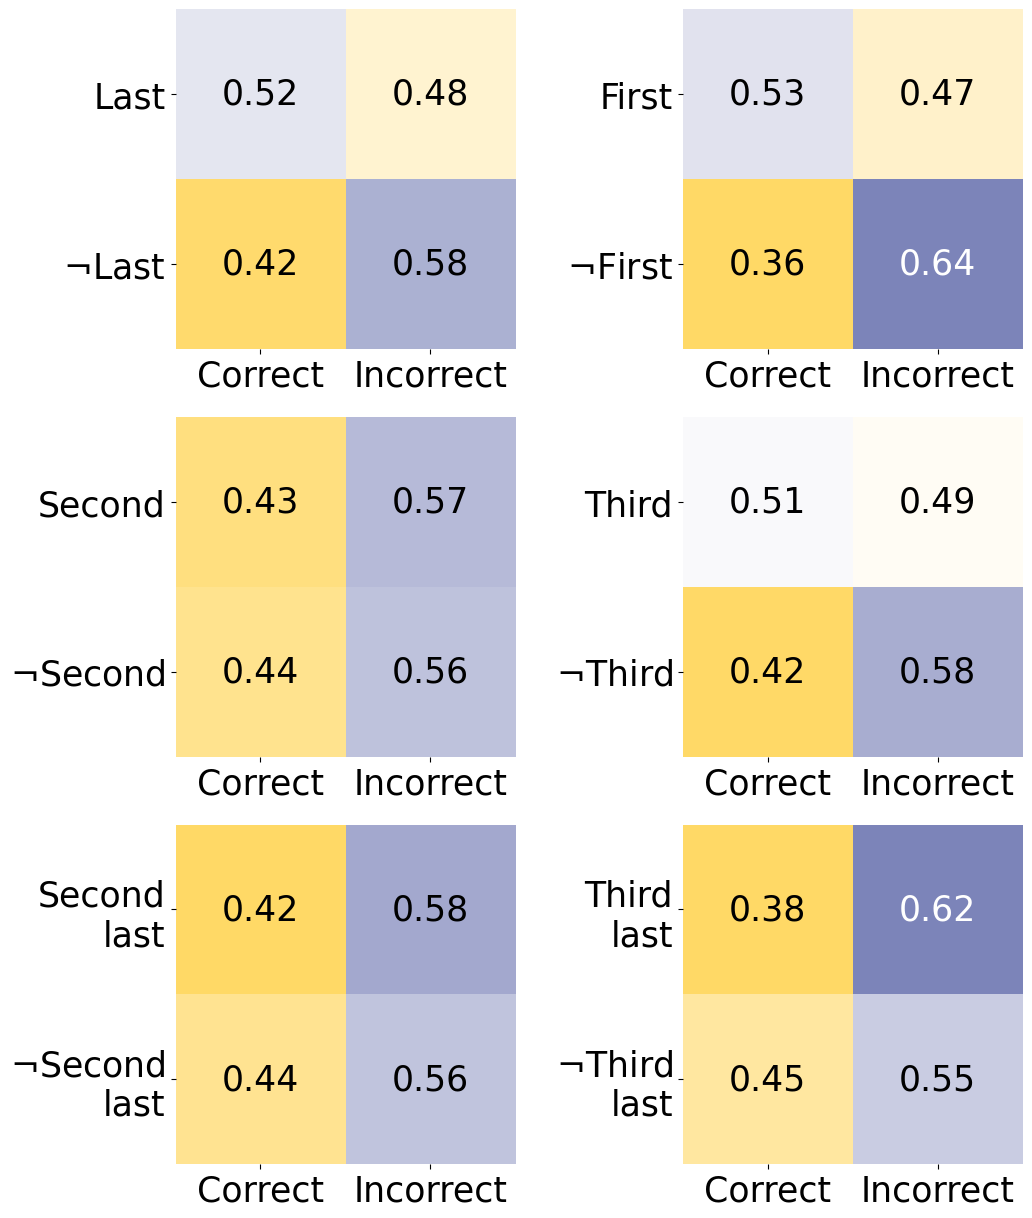

In [62]:
"""Claude other confusion matrix."""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 25
LEGEND_FONT_SIZE = 22
TITLE_FONT_SIZE = 30

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

colors = [(0, 'darksalmon'), (0.3, 'darksalmon'), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.8, '#7C84B9'), (1, '#7C84B9')]
# colors = [(0, (1, 0.851, 0.4)), (0.3, (1, 0.851, 0.4)), (0.5, 'white'), (0.7, 'steelblue'), (1, 'steelblue')]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", 
    colors
)

# Claude data
# Claude
last1, last2 = [0.5245901639344263, 0.42424242424242425]
last_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

first1, first2 = [0.526595744680851, 0.35960591133004927]
first_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])
# second
last1, last2 = [0.43396226415094336, 0.4421052631578947]
second_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

# third
last1, last2 = [0.5056179775280899, 0.4205298013245033]
third_confusion_claude = np.array([[last1, 1-last1], [last2, 1-last2]])

# last second
first1, first2 = [0.4166666666666667, 0.44314868804664725]
lastsecond_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])

# last third
first1, first2 =  [0.37500000000000006, 0.4507462686567164]
lastthird_confusion_claude = np.array([[first1, 1-first1], [first2, 1-first2]])

# plot
fig, axs = plt.subplots(3, 2, figsize=(15,15))
cmap = cmap
# cmap=mpl.colormaps['Blues']

titles = ['GPT-4', 'Claude']

im1 = axs[0][0].imshow(last_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)
im2 = axs[0][1].imshow(first_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)
im1 = axs[1][0].imshow(second_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)
im2 = axs[1][1].imshow(third_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)
im3 = axs[2][0].imshow(lastsecond_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)
im4 = axs[2][1].imshow(lastthird_confusion_claude, cmap=cmap, vmin=0.3, vmax=0.7)

for i, j in itertools.product(range(3), range(2)):
    axs[i][j].set_xticks(np.arange(2), rotation=0, labels=['Correct', 'Incorrect'])
    axs[0][0].set_yticks(np.arange(2), labels=['Last', r'$\neg$Last'])
    axs[0][1].set_yticks(np.arange(2), labels=['First', r'$\neg$First'])
    axs[1][0].set_yticks(np.arange(2), labels=['Second', r'$\neg$Second'])
    axs[1][1].set_yticks(np.arange(2), labels=['Third', r'$\neg$Third'])
    axs[2][0].set_yticks(np.arange(2), labels=['Second\nlast', r'$\neg$' + 'Second\nlast'])
    axs[2][1].set_yticks(np.arange(2), labels=['Third\nlast', r'$\neg$' + 'Third\nlast'])
    # communication = 'w/ deception, ' if j == 1 else 'w/o deception, '
    # axs[0][j].set_title(titles[j], fontsize=TITLE_FONT_SIZE, pad=20)
    for edge, spine in axs[i][j].spines.items():
            spine.set_visible(False)

# Loop over data dimensions and create text annotations.
matrices = {0: {0: last_confusion_claude, 1: first_confusion_claude},
            1: {0: second_confusion_claude, 1: third_confusion_claude},
            2: {0: lastsecond_confusion_claude, 1: lastthird_confusion_claude}}
for x, y, i, j in itertools.product(range(3), range(2), range(2), range(2)):
    data = matrices[x][y]
    rounded = np.round(data, 2)
    fontcolor = 'black' if data[i][j] < 0.6 else 'white'
    text = axs[x][y].text(j, i, rounded[i][j],
                ha="center", va="center", color=fontcolor)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, aspect=30)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")
cbar.outline.set_edgecolor('grey')
cbar.outline.set_linewidth(0.5)
cbar.remove()

plt.savefig('data_figs/confusion_Claude.pdf')
